In [3]:
import jax
import numpy as np
import numpy as onp
import jax.numpy as jnp
import optax
import chex
import haiku as hk
from tqdm import tqdm
import matplotlib.pyplot as plt

/home/anique/.local/lib/python3.10/site-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


# Plotting Functions

In [4]:
def plot_gradients(params, data, xlim=(-1.5, 2.0), ylim=(-1.5, 2.0), nx=50, ny=50, plot_scatter=True, alpha=1.0):
    xx = onp.stack(onp.meshgrid(onp.linspace(*xlim, nx), onp.linspace(*ylim, ny)), axis=-1).reshape(-1, 2)
    scores = m_apply(params, xx)
    scores_norm = onp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * onp.log1p(scores_norm)
    # Perform the plots

    if plot_scatter:
        plt.figure(figsize=(16,12))
        plt.scatter(data[:, 0], data[:, 1], alpha=0.3, color='red', edgecolor='black', s=40)
        plt.xlim(*xlim)
        plt.ylim(*ylim)

    quiver = plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='black', alpha=alpha)

    return quiver

# Create the Data

In [5]:
points1 = onp.stack([onp.random.normal((1, 1), 1) for x in range(500)])
points2 = onp.stack([onp.random.normal((50, 50), 5) for x in range(2000)])

In [6]:
data = onp.vstack([points1, points2])
onp.random.shuffle(data)

## Plot the Data

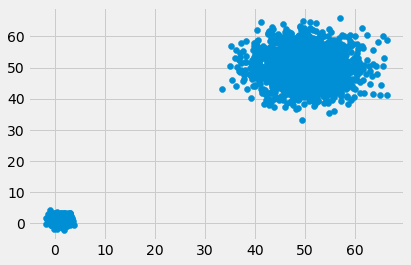

In [7]:
plt.style.use('fivethirtyeight')
plt.scatter(data[:, 0], data[:, 1])

# Model Definition

In [8]:
# Create a general model for the score
class MLP(hk.Module):
    def __init__(self, num_layers, hidden_size, output_size, name='score_mlp'):
        super(MLP, self).__init__(name=name)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size

    def __call__(self, x):
        p = x
        for i in range(self.num_layers - 1):
            p = hk.Linear(self.hidden_size)(p)
            p = jax.nn.softplus(p)
        p = hk.Linear(self.output_size)(p)
        return p

m_init, m_apply = hk.without_apply_rng(hk.transform(lambda x: MLP(3, 128, 2)(x)))

In [9]:
key =jax.random.PRNGKey(7)
key, split = jax.random.split(key)
m_params = m_init(key, data[:10])

# create and initialize the optimizer
optim = optax.adamw(0.003)
opt_state = optim.init(m_params)

/home/anique/.local/lib/python3.10/site-packages/haiku/_src/base.py:497: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)
/home/anique/.local/lib/python3.10/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/home/anique/.local/lib/python3.10/site-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


# Denoising Score Matching
The idea here is to add noise to the original data points and then train a model to predict the original data from the noise.
i.e. We create the distribution $q_\sigma(\tilde{x} |x) = \mathcal{N}(\tilde{x}|x, \sigma^2 I)$

then,
$$\nabla_\tilde{x}q_\sigma(\tilde{x}|x) = \frac{\tilde{x} - x}{\sigma}$$


In [10]:
# Create a simple model to estimate the score (Denoising Score Matching)
def score_loss(params, key, x, sigma):
    key, split = jax.random.split(key)
    noise = jax.random.normal(split, x.shape)
    perturbed = x + noise * sigma
    target = - noise
    # target = - noise * sigma
    # target = - noise * sigma # TODO Why is this division instead of multiplication?
    preds = m_apply(params, perturbed)
    loss = 0.5 * ((preds - target) ** 2).sum(axis=-1).mean(axis=0)
    return loss

score_loss_value_grad = jax.jit(jax.value_and_grad(score_loss))

In [11]:
NUM_ITERATIONS = 2000


for i in range(NUM_ITERATIONS):
    # Get a random batch of data
    batch_idxs = onp.random.choice(data.shape[0], size=128, replace=False)

    key, split = jax.random.split(key)
    # Get the loss
    loss_value, grads = score_loss_value_grad(m_params, split, data[batch_idxs], 20.)
    # optimize
    updates, opt_state = optim.update(grads, opt_state, m_params)
    m_params = optax.apply_updates(m_params, updates)

    # Print results
    if (i % 100) == 0:
        print(f'score matching loss: {loss_value}')

score matching loss: 129.5031280517578
score matching loss: 0.49540939927101135
score matching loss: 0.389850378036499
score matching loss: 0.36190780997276306
score matching loss: 0.4143062233924866
score matching loss: 0.422772616147995
score matching loss: 0.3013119399547577
score matching loss: 0.3097974956035614
score matching loss: 0.3286243677139282
score matching loss: 0.3122638463973999
score matching loss: 0.3059840202331543
score matching loss: 0.37269994616508484
score matching loss: 0.3992323577404022
score matching loss: 0.24514949321746826
score matching loss: 0.48666912317276
score matching loss: 0.1840057075023651
score matching loss: 0.2394561767578125
score matching loss: 0.3193814754486084
score matching loss: 0.25107860565185547
score matching loss: 0.23692651093006134


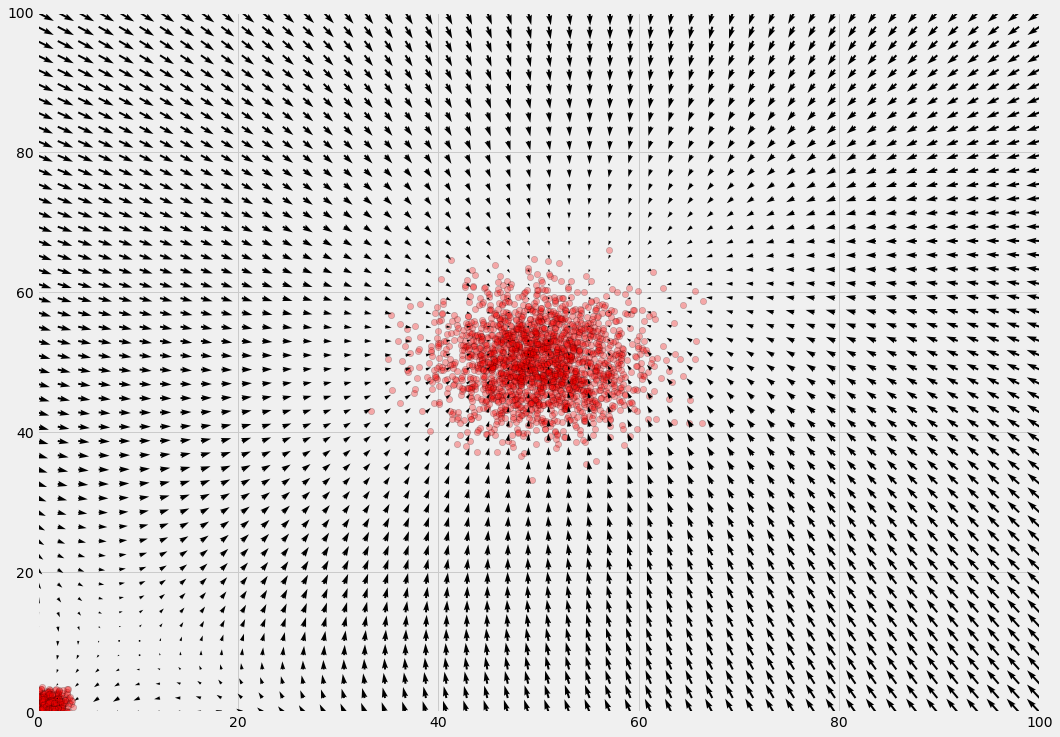

In [12]:
plot_gradients(m_params, data, xlim=(0,100), ylim=(0, 100))

# Noise Conditional Score Matching

## Create the model

In [13]:
class ConditionalLinear(hk.Module):
    def __init__(self, out_dim: int, num_enum, name=None):
        super(ConditionalLinear, self).__init__(name)
        self.out_dim = out_dim
        self.num_enum = num_enum

    def __call__(self, x: chex.Array, y: chex.Array):
        """
        Applies a function on the input given the condition represented by `y`
        :param x: input
        :param y: enum representing the sigma
        :return:
        """
        y_ = hk.Embed(self.num_enum, self.out_dim)(y)
        x_ = hk.Linear(self.out_dim)(x)
        return y_ * x_

class ConditionalModel(hk.Module):
    def __init__(self, num_layers, hidden_size, output_size, num_enum, name='score_conditional'):
        super(ConditionalModel, self).__init__(name=name)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_enum = num_enum

    def __call__(self, x, y):
        p = x
        for i in range(self.num_layers - 1):
            p = ConditionalLinear(self.hidden_size, self.num_enum)(p, y)
            p = jax.nn.softplus(p)
        p = ConditionalLinear(self.output_size, self.num_enum)(p, y)
        return p

In [14]:
max_distance = 0.
for i in range(len(data)):
    for j in range(len(data)):
        if i <= j:
            continue
        pointwise_dist = onp.sqrt( ( (data[i]-data[j])**2 ).sum())
        if pointwise_dist > max_distance:
            max_distance = pointwise_dist

In [15]:
L = 200 # number of standard deviations

# generate the standard deviations
sigmas = onp.linspace(0, onp.log(max_distance), L+1)[1:]
sigmas = onp.exp(sigmas)

m_init, m_apply = hk.without_apply_rng(hk.transform(lambda x, y: ConditionalModel(3, 128, 2, L)(x, y)))

key =jax.random.PRNGKey(7)
key, split = jax.random.split(key)
m_params = m_init(key, data[:10], jnp.zeros((10,), dtype=jnp.int16))

# create and initialize the optimizer
optim = optax.adamw(0.003)
opt_state = optim.init(m_params)


In [16]:
jax.tree_map(lambda x: x.shape, m_params)

{'score_conditional/conditional_linear/embed': {'embeddings': (200, 128)},
 'score_conditional/conditional_linear/linear': {'b': (128,), 'w': (2, 128)},
 'score_conditional/conditional_linear_1/embed': {'embeddings': (200, 128)},
 'score_conditional/conditional_linear_1/linear': {'b': (128,),
  'w': (128, 128)},
 'score_conditional/conditional_linear_2/embed': {'embeddings': (200, 2)},
 'score_conditional/conditional_linear_2/linear': {'b': (2,), 'w': (128, 2)}}

In [17]:
sigmas = jnp.array(sigmas)

In [18]:
def ncsn_loss(params, key, x, sigma_i):
    key, split = jax.random.split(key)
    noise = jax.random.normal(split, x.shape)
    actual_sigmas = sigmas[sigma_i][:, None]
    perturbed = x + noise * actual_sigmas
    target = - noise
    # target = - noise * sigma
    # target = - noise * sigma # TODO Why is this division instead of multiplication?
    preds = m_apply(params, perturbed, sigma_i)
    loss = 0.5 * ((preds - target) ** 2).sum(axis=-1).mean(axis=0)
    return loss

## Model Training

In [19]:
n_steps = 4000

ncsn_loss_value_grad = jax.jit(jax.value_and_grad(ncsn_loss))

for i in range(n_steps):
    batch_idxs = onp.random.choice(data.shape[0], 128, replace=False)
    sigma_is = onp.random.randint(0, L, 128, dtype=int)
    key, split = jax.random.split(key)
    loss, grad = ncsn_loss_value_grad(m_params, split, data[batch_idxs], sigma_is)
    updates, opt_state = optim.update(grad, opt_state, m_params)
    m_params = optax.apply_updates(m_params, updates)

    if i % 100 == 0:
        print(f'loss: {loss}')

loss: 137.31695556640625
loss: 2.752802610397339
loss: 1.1814440488815308
loss: 0.877907931804657
loss: 1.7552709579467773
loss: 1.0849111080169678
loss: 0.8898453712463379
loss: 0.8326245546340942
loss: 0.9626410007476807
loss: 0.7276343107223511
loss: 0.6653228998184204
loss: 0.8088992834091187
loss: 0.7160569429397583
loss: 0.6721668243408203
loss: 0.6620290279388428
loss: 0.7327885031700134
loss: 0.6847251653671265
loss: 0.6005285978317261
loss: 0.8613750338554382
loss: 0.6114215850830078
loss: 0.599734902381897
loss: 0.6284385323524475
loss: 0.5767102241516113
loss: 0.5602275729179382
loss: 0.5995585918426514
loss: 0.7112982273101807
loss: 0.6616947650909424
loss: 2.229081153869629
loss: 0.8440126180648804
loss: 0.4745693802833557
loss: 0.5487604141235352
loss: 0.6307647824287415
loss: 0.6260074973106384
loss: 0.6660832166671753
loss: 0.6313638687133789
loss: 0.5854849219322205
loss: 0.5970107913017273
loss: 0.5826770067214966
loss: 0.5595237016677856
loss: 0.6339349746704102


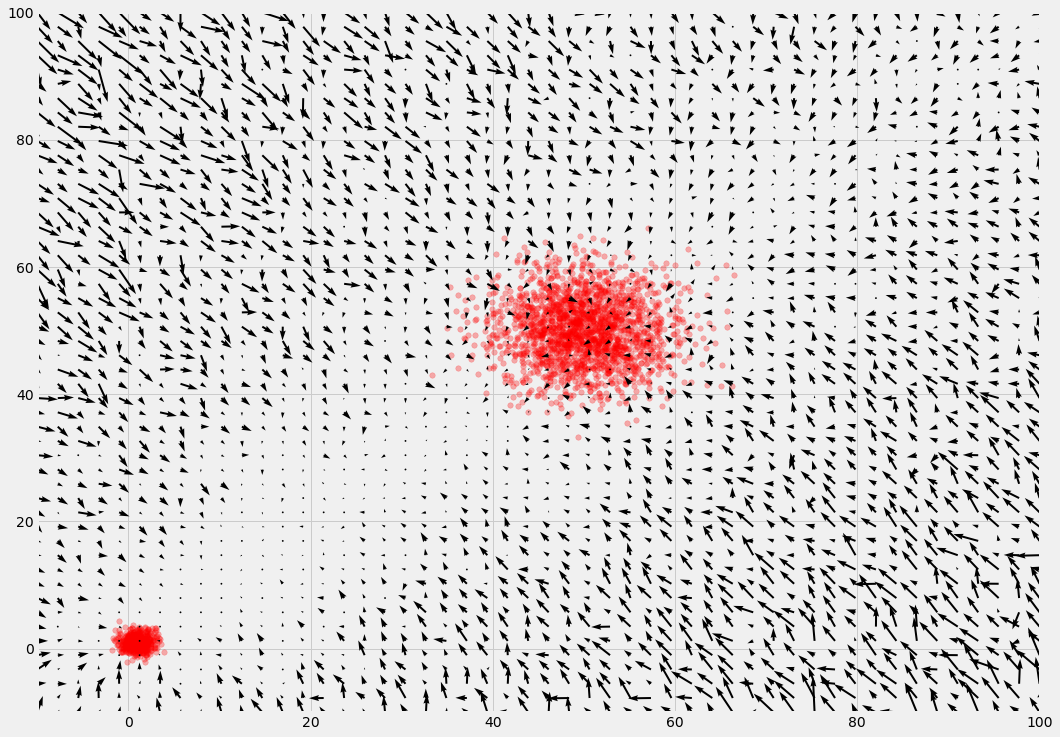

In [20]:
xx = onp.stack(onp.meshgrid(onp.linspace(-10, 100, 50), onp.linspace(-10, 100, 50)), axis=-1).reshape(-1, 2)
labels = onp.random.randint(0, len(sigmas), (xx.shape[0],))
# labels = onp.ones((xx.shape[0], 1)) * (L-1)
# scores = m_apply(m_params, xx, onp.ones((xx.shape[0],), dtype=int) * 140)
scores = m_apply(m_params, xx, labels)
scores_norm = onp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * onp.log1p(scores_norm)
# Perform the plots
plt.figure(figsize=(16,12))
plt.scatter(*data.T, alpha=0.3, color='red', s=30)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='black')
plt.xlim(-10, 100)
plt.ylim(-10, 100);



# Annealed Langevin Sampling
We start off at a random point and then follow the direction of the gradient combined with some noise. Formally our movement is defined by the following equation:
$$
x_{t+1} = x_{t} + \frac{\epsilon}{2} \nabla_{x_t}\log{p(x_t)} + \sqrt{\epsilon}z_t
$$

In [65]:
def langevin_step(m_params, key, x, step_idx, alpha):
    key, split = jax.random.split(key)
    # draw a normal noise
    noise = jax.random.normal(split, x.shape)
    x_t = x + alpha * m_apply(m_params, x, jnp.repeat(step_idx, x.shape[0])) + jnp.sqrt(2 * alpha) * noise
    return x_t


def annealed_langevin(m_params, key, x, epsilon):
    def langevin_t(key_x_t, l_i):
        key, x_t = key_x_t
        key, split = jax.random.split(key)
        alpha = epsilon * (sigmas[l_i] ** 2) / (sigmas[0] ** 2)
        x = langevin_step(m_params, split, x_t, l_i, alpha)
        return (key, x), x
    (_, final_x), path = jax.lax.scan(langevin_t, (key, x), jnp.arange(L)[::-1])
    return final_x, path

print(type(annealed_langevin))
annealed_langevin = jax.jit(annealed_langevin)
print(type(annealed_langevin))


<class 'function'>
<class 'jaxlib.xla_extension.CompiledFunction'>


In [61]:
key, split = jax.random.split(key)

In [62]:
data[:3]

array([[48.28378976, 56.58689638],
       [ 1.13955658,  3.361253  ],
       [51.25497426, 55.26213287]])

In [63]:
_, a = annealed_langevin(m_params, split, data[:3], 1e-3)

/home/anique/.local/lib/python3.10/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/home/anique/.local/lib/python3.10/site-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


In [64]:
a[0]

DeviceArray([[44.63622 , 51.417263],
             [-4.723916,  9.821861],
             [44.9003  , 47.67761 ]], dtype=float32)